#**Character CNN**

Vinayak Gupta, 31st May 2021

I have implemented the Character CNN model. This architecture basically uses CNN for NLP but character wise. We try to stack the letter vectors to form a matrix and on that we apply the convolution operation.

**Character CNN** 

The information which I am sharing is mostly from this paper. So if you want a very good understanding of the model, you can have a look at the paper [link text](https://arxiv.org/pdf/1509.01626.pdf)

**Dataset Download** 

The dataset is from a Kaggle competition called Quora Insincere Questions Classification. You can download the dataset from the link [link text](https://www.kaggle.com/c/quora-insincere-questions-classification/data)

**Special Note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

In [ ]:
import torch

import pandas as pd
import numpy as np
!pip install pyprind
import pyprind
import random
import torch.nn.functional as F

import io
import unicodedata
import string
import glob

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import random
import os
import spacy
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import nltk
import torchtext
import matplotlib.pyplot as plt 
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ALL_LETTERS = '''abcdefghijklmnopqrstuvwxyz0123456789–,;.!?:"'/\|_@#$%^&*~`+-=<>()[]{} '''
N_LETTERS = len(ALL_LETTERS)
print(N_LETTERS)

#**Data Processing**

In [ ]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

# Find Letter Index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1,N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a < line_length x 1 x n_letters>
# or an array of one hot letter vectors

def line_to_tensor(line):
    tensor = torch.zeros(1, N_LETTERS, len(line))
    for i, letter in enumerate(line):
        tensor[0][letter_to_index(letter)][i] = 1
    return tensor

main_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Quora Insincere Dataset/train.csv'))
main_df = main_df.sample(n=main_df.shape[0])
main_df = main_df[["question_text", "target"]]
#main_df = main_df.iloc[0:12000, :]

o_class = main_df.loc[main_df.target == 0, :]
l_class = main_df.loc[main_df.target == 1, :]

train_o = o_class.iloc[0:6000, :]
train_l = l_class.iloc[0:6000, :]

main_df = pd.concat([train_o, train_l], axis=0)
                    

In [ ]:
class CreateDataset(torch.utils.data.Dataset):

    def __init__(self, PATH, batch_size=32):
        self.PATH = PATH
        self.batch_size = batch_size
        self.initData()

    def initData(self):
        main_df = pd.read_csv(os.path.join(self.PATH))
        main_df = main_df.sample(n=main_df.shape[0])
        self.question_text = main_df[["question_text"]]
        self.target = main_df[["target"]]

    def __getitem__(self, index):

        question = line_to_tensor(self.question_text.iloc[index, 0])
        pad = torch.zeros([1, 70, 300 - question.shape[2]])
        question = torch.cat((question,pad), 2)
        tgt = self.target.iloc[index, 0]
        tgt = torch.tensor(tgt, dtype = torch.long)
        return question, tgt
    
    def __len__(self):
        return len(main_df[["question_text"]])

trainset = CreateDataset('/content/drive/MyDrive/Quora Insincere Dataset/train.csv')
train_dataset, val_dataset = random_split(trainset, [11800, 200])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

#**Character CNN**

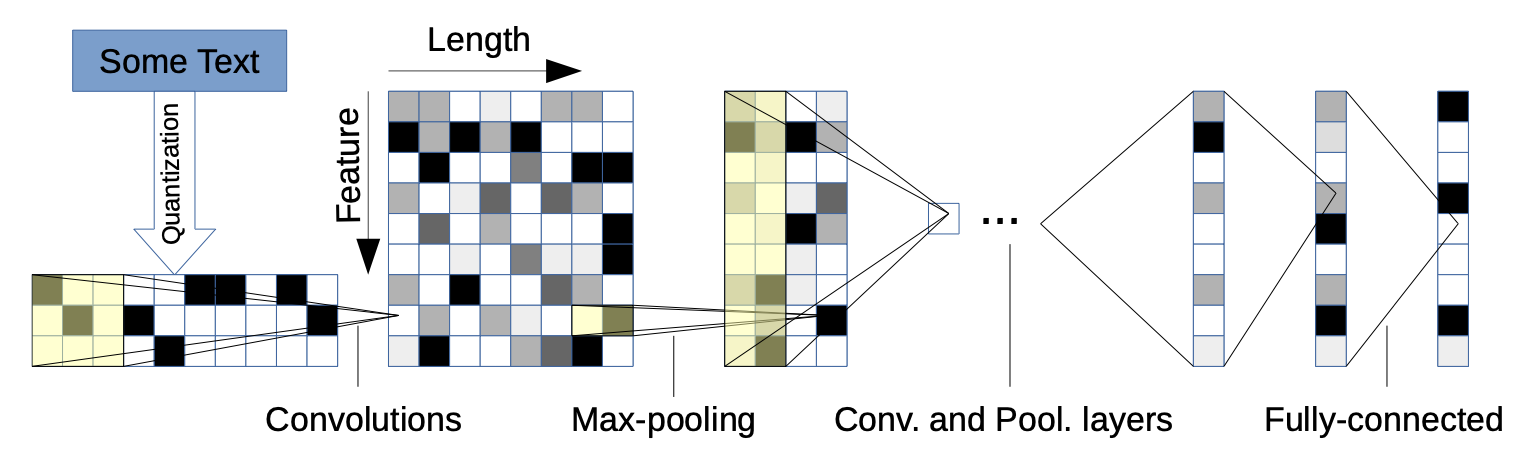

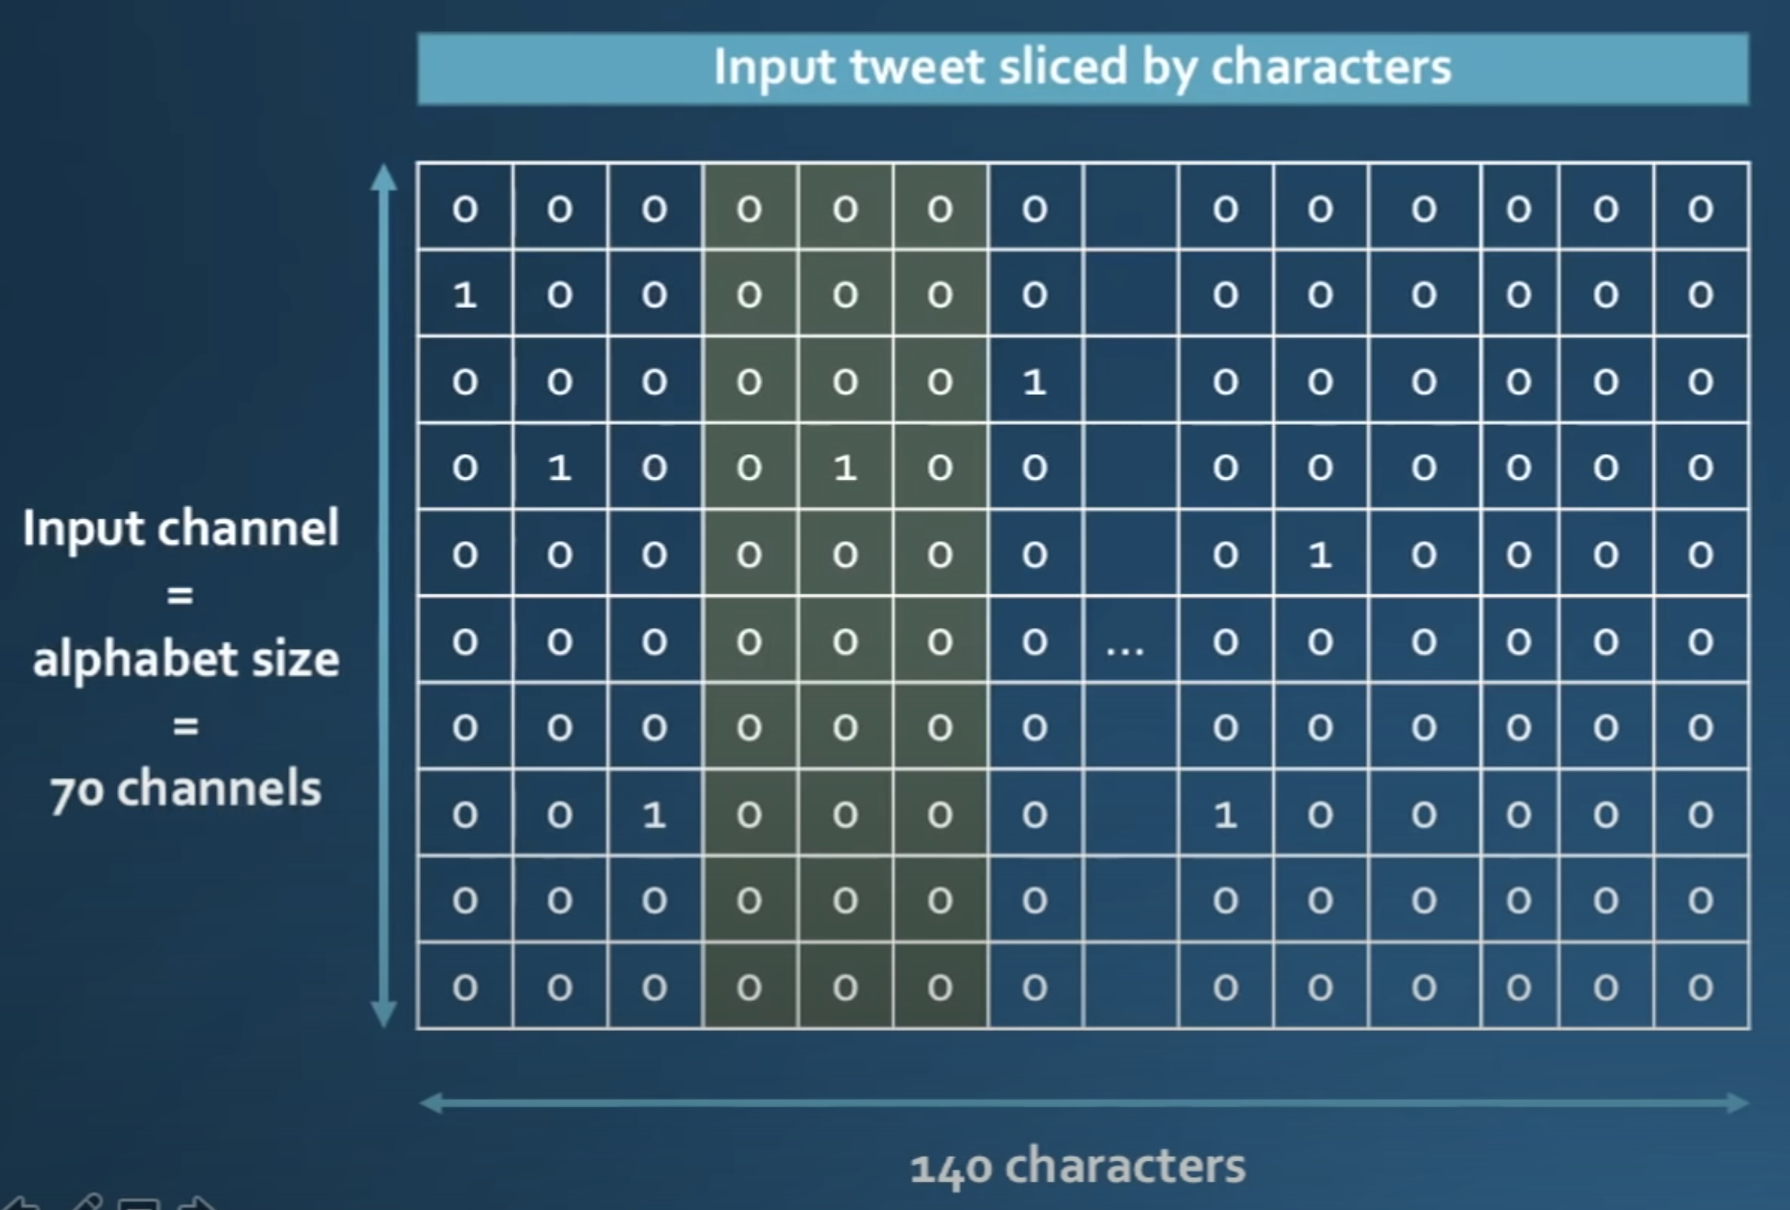

In [ ]:
class CharCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels = 70, out_channels = 256, kernel_size = 7, stride = 1)
        self.maxpool = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv1d(in_channels = 256, out_channels = 256, kernel_size = 7, stride = 1)
        self.conv3 = nn.Conv1d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1)
        self.fc1 = nn.Linear(7936, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024,1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, text):
        
        x = self.conv1(text)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = torch.reshape(x, (-1, 1, 7936))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

model = CharCNN()

In [ ]:
epoch_train_losses = []              # Defining an empty list to store the epoch losses
epoch_val_losses = []              # Defining an empty list to store the epoch losses
accu_train_epoch = []
accu_val_epoch = []

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

def make_tensor(tensor):
  if torch.cuda.is_available():
    return torch.cuda.FloatTensor(tensor)
  else:
    return torch.FloatTensor(tensor)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    train_loss_batch = []
    accu_train_batch = []
    model.train()
    #bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for idx, (text, label) in enumerate(iterator):
        
        text = text.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        text = torch.reshape(text, (-1, 70, 300))
        predictions = model(make_tensor(text))
        label = (label).type_as(predictions)
        label = label.view(text.shape[0])
        predictions = predictions.view(text.shape[0])
        train_loss = criterion(predictions, label)
        acc = binary_accuracy(predictions, label)
        
        train_loss.backward()
        optimizer.step()
        
        train_loss_batch.append(train_loss)
        accu_train_batch.append(acc)
        #bar.update()
        
    epoch_train_losses.append(sum(train_loss_batch)/len(iterator))
    accu_train_epoch.append(sum(accu_train_batch)/len(iterator))

    return epoch_train_losses[-1], accu_train_epoch[-1]

def evaluate(model, iterator, criterion):
    
    val_loss_batch = []
    accu_val_batch = []
    model.eval()
    
    with torch.no_grad():
        #bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for idx, (text, label) in enumerate(iterator):
            text = text.to(device)
            label = label.to(device)    
            text = torch.reshape(text, (-1, 70, 300))
            predictions = model(make_tensor(text))
            label = (label).type_as(predictions)
            label = label.view(text.shape[0])
            predictions = predictions.view(text.shape[0])
            val_loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            val_loss_batch.append(val_loss)
            accu_val_batch.append(acc)
            #bar.update()

        epoch_val_losses.append(sum(val_loss_batch)/len(iterator))
        accu_val_epoch.append(sum(accu_val_batch)/len(iterator))
    return epoch_val_losses[-1], accu_val_epoch[-1]

In [ ]:
epochs = 10

for epoch in range(epochs):

    train_loss, train_acc = train(model, trainloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valloader, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.225 | Train Acc: 94.15% | Val. Loss: 0.185 | Val. Acc: 95.98% |
| Epoch: 02 | Train Loss: 0.218 | Train Acc: 94.13% | Val. Loss: 0.184 | Val. Acc: 95.98% |
| Epoch: 03 | Train Loss: 0.189 | Train Acc: 94.30% | Val. Loss: 0.103 | Val. Acc: 96.88% |
| Epoch: 04 | Train Loss: 0.140 | Train Acc: 95.08% | Val. Loss: 0.091 | Val. Acc: 96.88% |
| Epoch: 05 | Train Loss: 0.096 | Train Acc: 96.42% | Val. Loss: 0.073 | Val. Acc: 97.77% |
| Epoch: 06 | Train Loss: 0.055 | Train Acc: 98.05% | Val. Loss: 0.199 | Val. Acc: 95.54% |
| Epoch: 07 | Train Loss: 0.039 | Train Acc: 98.80% | Val. Loss: 0.136 | Val. Acc: 97.32% |
| Epoch: 08 | Train Loss: 0.018 | Train Acc: 99.42% | Val. Loss: 0.105 | Val. Acc: 97.32% |
| Epoch: 09 | Train Loss: 0.010 | Train Acc: 99.75% | Val. Loss: 0.079 | Val. Acc: 98.66% |
| Epoch: 10 | Train Loss: 0.012 | Train Acc: 99.66% | Val. Loss: 0.093 | Val. Acc: 98.66% |


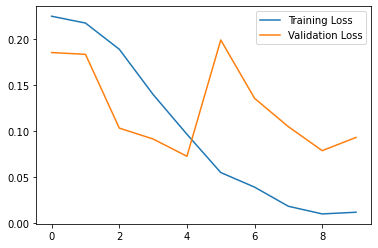

In [ ]:
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.legend()
plt.show()

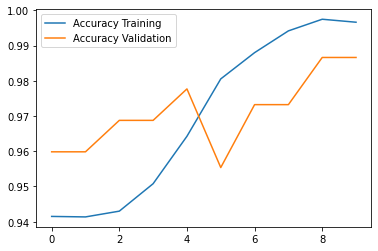

In [ ]:
plt.plot(accu_train_epoch, label='Accuracy Training')
plt.plot(accu_val_epoch, label='Accuracy Validation')
plt.legend()
plt.show()

#**Testing**

In [ ]:
def predict_sentiment(model, question):
    
    model.eval()
    text = line_to_tensor(question)
    pad = torch.zeros([1, 70, 300 - text.shape[2]])
    text = torch.cat((text,pad), 2)
    prediction = torch.sigmoid(model(text))
    return prediction.item()

predict_sentiment(model, "Happy Nice Boy in the world")

#**Advantage of Character CNN**

1. No Text Processing

2. Good Handling of misspelled words/out of vocabulary words

3. Fast Training